In [1]:
!pip install networkx

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [3]:
df = pd.read_csv('X:\RA_AirQuality\combined_final_dataset.csv', index_col='DateTime')

In [4]:
df.head()

,TEMP,CO,NO,NO2,PM10,PM2.5,HUM,DIR,SPD,PRES,Month,Hour,TF_CNT
DateTime,,,,,,,,,,,,,
2019-01-01 00:00:00,-13.26,0.28,1.66,7.00,8.62,6.30,80.04,189.90,2.65,625.00,1,0,2042.0
2019-01-01 01:00:00,-14.22,0.27,0.66,6.00,8.71,4.41,75.21,282.43,2.70,625.24,1,1,1949.0
2019-01-01 02:00:00,-14.30,0.29,0.63,7.31,6.82,5.24,79.09,310.47,2.26,630.04,1,2,1527.0
2019-01-01 03:00:00,-14.44,0.29,0.56,6.42,9.10,6.56,79.54,295.01,2.18,630.40,1,3,1403.0
2019-01-01 04:00:00,-14.82,0.29,0.72,8.13,5.94,4.70,79.86,298.92,1.55,630.40,1,4,1793.0


In [5]:
df=df[pd.isnull(df['PM2.5'])==False]

In [6]:
# df = df.drop(columns=['Month','Hour'])

In [7]:
df=df.fillna(df.mean())

In [8]:
df.isnull().values.any()

False

In [9]:
df.shape

(7273, 13)

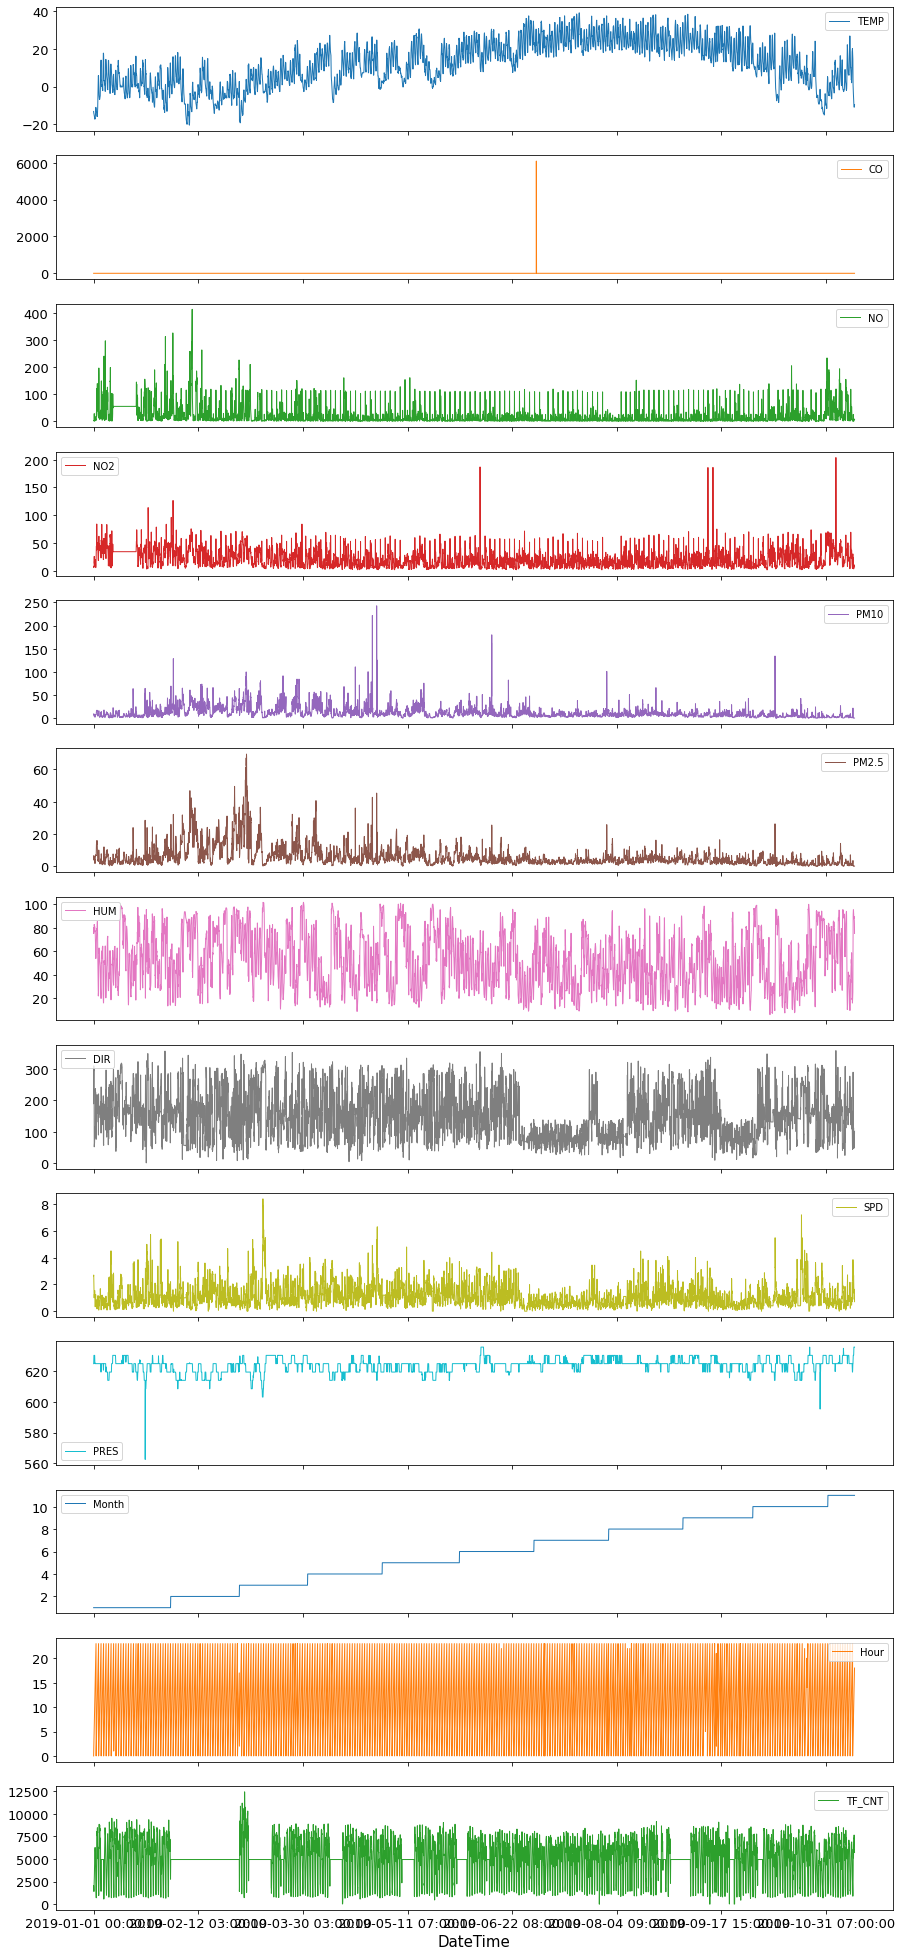

In [10]:
df.plot(figsize=(15,35), linewidth=1, fontsize=13, subplots=True)
plt.xlabel('DateTime', fontsize=15);

In [11]:
# # GRANGER CAUSALITY TEST

# import warnings
# warnings.filterwarnings('ignore')

# from statsmodels.tsa.stattools import grangercausalitytests
# maxlag=12
# test = 'ssr_chi2test'
# def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
#     """Check Granger Causality of all possible combinations of the Time series.
#     The rows are the response variable, columns are predictors. The values in the table 
#     are the P-Values. P-Values lesser than the significance level (0.05), implies 
#     the Null Hypothesis that the coefficients of the corresponding past values is 
#     zero, that is, the X does not cause Y can be rejected.
#     """
#     df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
#     for c in df.columns:
#         for r in df.index:
#             test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
#             p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
#             if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
#             min_p_value = np.min(p_values)
#             df.loc[r, c] = min_p_value
#     df.columns = [var + '_x' for var in variables]
#     df.index = [var + '_y' for var in variables]
#     return df

# gc = grangers_causation_matrix(df, variables = df.columns)   

In [12]:
# # COINTEGRATION TEST : When two or more time series are cointegrated, it means they have a long run,
# # statistically significant relationship.

# from statsmodels.tsa.vector_ar.vecm import coint_johansen

# def cointegration_test(df, alpha=0.05): 
#     """Perform Johanson's Cointegration Test and Report Summary"""
#     out = coint_johansen(df,-1,5)
#     d = {'0.90':0, '0.95':1, '0.99':2}
#     traces = out.lr1
#     cvts = out.cvt[:, d[str(1-alpha)]]
#     def adjust(val, length= 6): return str(val).ljust(length)

#     # Summary
#     print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
#     for col, trace, cvt in zip(df.columns, traces, cvts):
#         print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

# cointegration_test(df)

In [13]:
# DATA SPLIT into train and test

nobs = 2500
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)
print(df_test.shape)

(4773, 13)
(2500, 13)


In [14]:
# TIME SERIES STATIONARITY CHECK (Just to refresh, a stationary time series is one whose 
# characteristics like mean and variance does not change over time)

# Perform Unit-Root Tests (eg. ADF Test, KPSS test, etc.)

def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [15]:
# ADF Test on each column
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.9071
 No. Lags Chosen       = 25
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.002. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -69.0561
 No. Lags Chosen       = 0
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "NO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [16]:
# 1st difference, since Hour was not stationary (Remove variable hour/month later)
df_differenced = df_train.diff().dropna()

In [17]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "TEMP" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.3953
 No. Lags Chosen       = 24
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "CO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -20.6702
 No. Lags Chosen       = 32
 Critical value 1%     = -3.432
 Critical value 5%     = -2.862
 Critical value 10%    = -2.567
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "NO" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05


In [18]:
# Select the Order (P) of VAR model by looking at AIC, BIC, FPE, HQIC scores

model = VAR(df_train)
for i in range(50):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 0
AIC :  68.3892515683128
BIC :  68.40687559808886
FPE :  5.024288598902856e+29
HQIC:  68.39544306945501 

Lag Order = 1
AIC :  43.92262663784085
BIC :  44.16940676829886
FPE :  1.1894726882496911e+19
HQIC:  44.00932393147708 

Lag Order = 2
AIC :  43.21310658136837
BIC :  43.689124027005796
FPE :  5.850788732856842e+18
HQIC:  43.38033990971811 

Lag Order = 3
AIC :  43.09272146341217
BIC :  43.798057485135196
FPE :  5.187204397891945e+18
HQIC:  43.340521086482454 

Lag Order = 4
AIC :  42.99844088262094
BIC :  43.93317678778082
FPE :  4.720530113728445e+18
HQIC:  43.32683707822051 

Lag Order = 5
AIC :  42.951055862299185
BIC :  44.115273004728586
FPE :  4.5021145106687995e+18
HQIC:  43.360078926052694 

Lag Order = 6
AIC :  42.87959217240014
BIC :  44.27337195244951
FPE :  4.1916730515497846e+18
HQIC:  43.369272417762346 

Lag Order = 

C:\Users\Sohil\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


7
AIC :  42.52956467173984
BIC :  44.15298853631386
FPE :  2.9538084858760745e+18
HQIC:  43.09993243000988 

Lag Order = 8
AIC :  42.39044943308284
BIC :  44.24359887567687
FPE :  2.570268886594577e+18
HQIC:  43.041535053418414 

Lag Order = 9
AIC :  42.38102547247528
BIC :  44.463982033211835
FPE :  2.546259822532228e+18
HQIC:  43.11285932190696 

Lag Order = 10
AIC :  42.380541051614564
BIC :  44.693386317279874
FPE :  2.5451504685074053e+18
HQIC:  43.19315351506002 

Lag Order = 11
AIC :  42.37374945512476
BIC :  44.91656505920532
FPE :  2.5280735233602033e+18
HQIC:  43.26717093540308 

Lag Order = 12
AIC :  42.35501199621726
BIC :  45.12787961893643
FPE :  2.481321565905284e+18
HQIC:  43.32927291406324 

Lag Order = 13
AIC :  42.31059956396245
BIC :  45.31360093231713
FPE :  2.3737310341022065e+18
HQIC:  43.365730358040885 

Lag Order = 14
AIC :  42.30203920983373
BIC :  45.535256097630985
FPE :  2.3537287186322816e+18
HQIC:  43.43807033675378 

Lag Order = 15
AIC :  42.29288716864

In [19]:
x = model.select_order(maxlags=50)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.37,68.39,4.950e+29,68.38
1,43.99,44.23,1.267e+19,44.07
2,43.28,43.76*,6.240e+18,43.45
3,43.16,43.87,5.541e+18,43.41
4,43.06,44.00,5.029e+18,43.39
5,43.01,44.19,4.787e+18,43.42
6,42.94,44.35,4.460e+18,43.44
7,42.59,44.23,3.140e+18,43.17
8,42.45,44.32,2.729e+18,43.11*
9,42.44,44.54,2.697e+18,43.18


In [20]:
model_fitted = model.fit(25)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 09, Jul, 2021
Time:                     10:37:00
--------------------------------------------------------------------
No. of Equations:         13.0000    BIC:                    47.1889
Nobs:                     4748.00    HQIC:                   43.4458
Log likelihood:          -181671.    FPE:                9.74494e+17
AIC:                      41.4179    Det(Omega_mle):     4.11020e+17
--------------------------------------------------------------------
Results for equation TEMP
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const            -10.012426         2.999219           -3.338           0.001
L1.TEMP            1.236247         0.022833           54.143           0.000
L1.CO              0.000298         0.000192            1.548           0

In [21]:
# Check for Serial Correlation of Residuals (Errors) using Durbin Watson Statistic

from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(col, ':', round(val, 2))

TEMP : 2.0
CO : 2.0
NO : 2.0
NO2 : 2.01
PM10 : 2.0
PM2.5 : 2.0
HUM : 2.0
DIR : 2.0
SPD : 1.99
PRES : 2.01
Month : 2.0
Hour : 2.02
TF_CNT : 2.0


In [22]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 12

# Input data for forecasting
forecast_input = df_train.values[-lag_order:]
forecast_input

25


array([[2.0940e+01, 6.0000e-02, 7.6000e-01, 1.1770e+01, 4.9000e+00,
        3.1000e+00, 5.6940e+01, 1.4709e+02, 7.2000e-01, 6.3031e+02,
        7.0000e+00, 1.0000e+01, 4.8940e+03],
       [2.0450e+01, 2.2000e-01, 2.8000e+00, 1.8170e+01, 4.8800e+00,
        3.1800e+00, 6.0520e+01, 1.5386e+02, 6.6000e-01, 6.3031e+02,
        7.0000e+00, 1.1000e+01, 6.1480e+03],
       [1.9800e+01, 4.2000e-01, 6.5400e+00, 2.0610e+01, 5.8900e+00,
        3.5400e+00, 6.2200e+01, 1.5508e+02, 7.0000e-01, 6.3040e+02,
        7.0000e+00, 1.2000e+01, 6.4640e+03],
       [2.0120e+01, 4.8000e-01, 2.2800e+01, 2.7920e+01, 7.2200e+00,
        3.9800e+00, 5.8200e+01, 1.4869e+02, 7.3000e-01, 6.3040e+02,
        7.0000e+00, 1.3000e+01, 6.6190e+03],
       [2.2540e+01, 4.7000e-01, 4.8560e+01, 3.0100e+01, 1.0030e+01,
        4.4200e+00, 5.0860e+01, 1.5977e+02, 9.4000e-01, 6.3040e+02,
        7.0000e+00, 1.4000e+01, 6.5160e+03],
       [2.4830e+01, 4.4000e-01, 2.6980e+01, 2.6630e+01, 9.8600e+00,
        4.3000e+00, 4.3900e

In [23]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_forecast')
df_forecast

,TEMP_forecast,CO_forecast,NO_forecast,NO2_forecast,PM10_forecast,PM2.5_forecast,HUM_forecast,DIR_forecast,SPD_forecast,PRES_forecast,Month_forecast,Hour_forecast,TF_CNT_forecast
DateTime,,,,,,,,,,,,,
2019-07-25 11:00:00,21.457692,22.019037,16.599232,21.145979,8.350013,3.500083,55.164608,160.756624,0.768976,625.042156,6.997682,11.440811,6432.949603
2019-07-25 12:00:00,20.890989,7.740812,22.340135,22.384868,10.297344,3.582222,58.877175,137.695061,0.777089,625.185685,6.997089,11.490018,6410.424277
2019-07-25 13:00:00,21.485889,19.206845,26.265055,23.075230,10.569463,3.330595,58.129829,150.144937,0.719343,625.526981,6.991000,13.009618,6519.792079
2019-07-25 14:00:00,23.119606,27.326787,30.969419,22.975011,14.019121,4.053832,52.199400,151.217866,0.755688,625.812784,6.993049,13.612362,6057.322971
2019-07-25 15:00:00,25.301608,-10.291212,18.149797,17.430604,8.974577,2.931569,45.095754,140.382550,0.833424,625.730332,6.994687,14.703257,5334.328402
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-11-11 14:00:00,33.082096,5.245422,-11.024587,4.952959,8.000718,1.659770,41.238918,108.112064,1.002697,625.726408,8.897527,12.051839,4789.410356
2019-11-11 15:00:00,33.190689,5.287460,-11.179236,4.820837,8.031584,1.652077,40.932567,108.092404,1.012103,625.715413,8.898214,12.065284,4756.288113
2019-11-11 16:00:00,33.289867,5.327125,-11.341382,4.709393,8.049897,1.642141,40.661762,108.067238,1.020480,625.705039,8.898943,12.038621,4720.355693


In [24]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
#     for col in columns:        
#         # Roll back 2nd Diff
#         if second_diff:
#             df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
# #         Roll back 1st Diff
#         df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [25]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)        
df_results.loc[:, ['TEMP_forecast', 'CO_forecast', 'NO_forecast', 'NO2_forecast', 'PM10_forecast', 'PM2.5_forecast', 'HUM_forecast', 'DIR_forecast', 'SPD_forecast', 'PRES_forecast', 'TF_CNT_forecast']]

,TEMP_forecast,CO_forecast,NO_forecast,NO2_forecast,PM10_forecast,PM2.5_forecast,HUM_forecast,DIR_forecast,SPD_forecast,PRES_forecast,TF_CNT_forecast
DateTime,,,,,,,,,,,
2019-07-25 11:00:00,21.457692,22.019037,16.599232,21.145979,8.350013,3.500083,55.164608,160.756624,0.768976,625.042156,6432.949603
2019-07-25 12:00:00,20.890989,7.740812,22.340135,22.384868,10.297344,3.582222,58.877175,137.695061,0.777089,625.185685,6410.424277
2019-07-25 13:00:00,21.485889,19.206845,26.265055,23.075230,10.569463,3.330595,58.129829,150.144937,0.719343,625.526981,6519.792079
2019-07-25 14:00:00,23.119606,27.326787,30.969419,22.975011,14.019121,4.053832,52.199400,151.217866,0.755688,625.812784,6057.322971
2019-07-25 15:00:00,25.301608,-10.291212,18.149797,17.430604,8.974577,2.931569,45.095754,140.382550,0.833424,625.730332,5334.328402
...,...,...,...,...,...,...,...,...,...,...,...
2019-11-11 14:00:00,33.082096,5.245422,-11.024587,4.952959,8.000718,1.659770,41.238918,108.112064,1.002697,625.726408,4789.410356
2019-11-11 15:00:00,33.190689,5.287460,-11.179236,4.820837,8.031584,1.652077,40.932567,108.092404,1.012103,625.715413,4756.288113
2019-11-11 16:00:00,33.289867,5.327125,-11.341382,4.709393,8.049897,1.642141,40.661762,108.067238,1.020480,625.705039,4720.355693


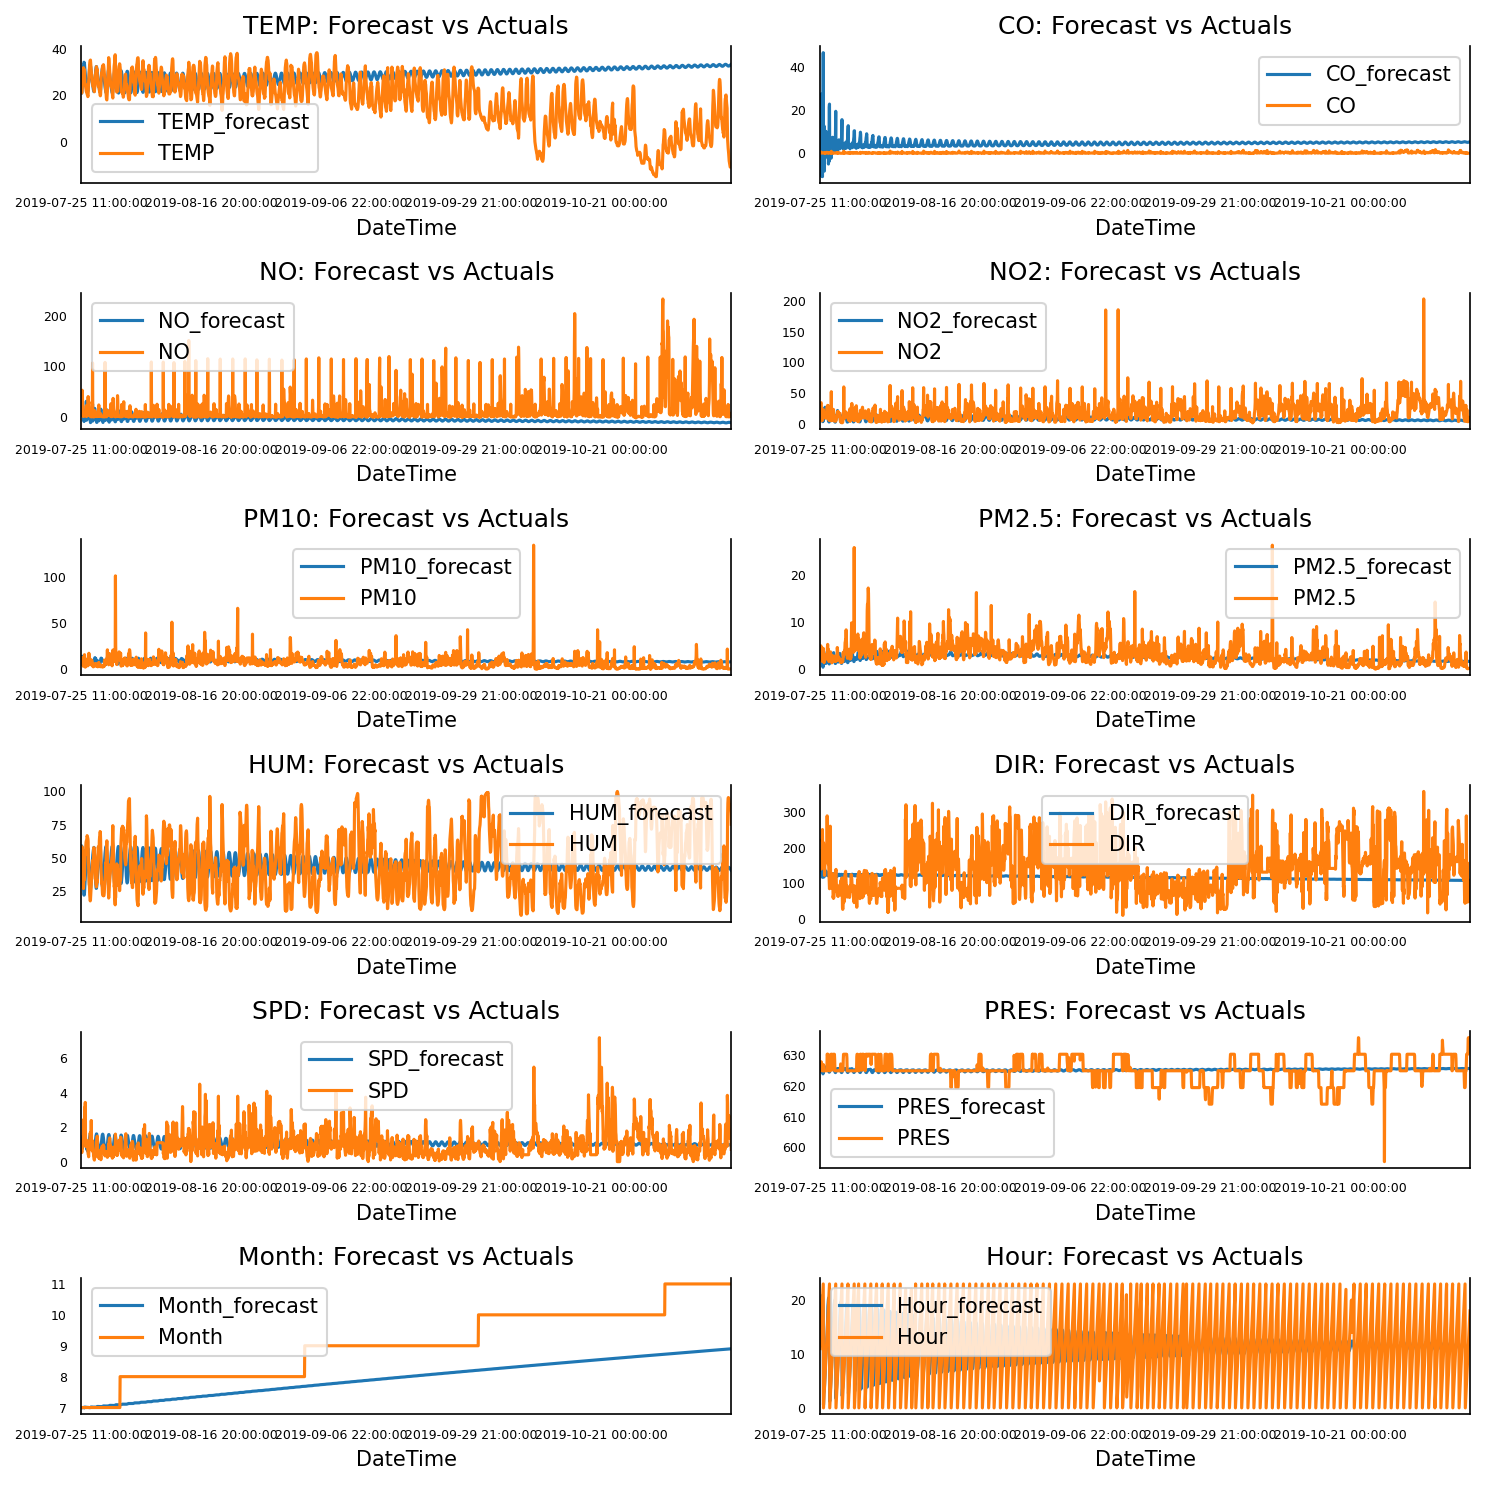

In [26]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [27]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
#     corr = np.corrcoef(forecast, actual)[0,1]   # corr
#     mins = np.amin(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     maxs = np.amax(np.hstack([forecast[:,None], 
#                               actual[:,None]]), axis=1)
#     minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
#             'corr':corr, 'minmax':minmax
           })

# print('Forecast Accuracy of: TEMP')
# accuracy_prod = forecast_accuracy(df_results['TEMP_forecast'].values, df_test['TEMP'])
# for k, v in accuracy_prod.items():
#     print(k, ': ', round(v,4))

print('\nForecast Accuracy of: PM2.5')
accuracy_prod = forecast_accuracy(df_results['PM2.5_forecast'].values, df_test['PM2.5'])
for k, v in accuracy_prod.items():
    print(k, ': ', round(v,4))


Forecast Accuracy of: PM2.5
mape :  0.9013
me :  -0.7587
mae :  1.534
mpe :  0.4904
rmse :  2.332
